In [37]:
import os
import json
import re
import time
import copy
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [38]:
# Configuration Constants

# --- Dataset Paths ---
DATASET_PATH = "../TestDataSet"  # Root path to original dataset (ImageFolder format)
LABEL_JSON_PATH = os.path.join(DATASET_PATH, "labels_list.json")  # Mapping of folder order to ImageNet indices
ADV_DATASET_PATH_TASK3 = "../AdversarialTestSet2_PGD_Refactored"  # Output path for PGD adversarial images

# --- Device & Model ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WEIGHTS = "IMAGENET1K_V1"  # Pretrained weights identifier

# --- PGD Attack Settings ---
EPSILON = 0.02          # Max perturbation (L-infinity norm, scaled to [0, 1] range)
PGD_ALPHA = 0.005       # Step size for each PGD iteration
PGD_ITERS = 5           # Total number of PGD iterations

# --- DataLoader Settings ---
BATCH_SIZE = 32         # Batch size for data loading
NUM_WORKERS = 0         # Number of subprocesses for data loading (tune as needed)


In [39]:
resnet34 = torchvision.models.resnet34(weights=WEIGHTS)
resnet34 = resnet34.to(DEVICE)
resnet34.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Normalization and Visualization Settings

Here we define key normalization parameters and visualization settings:

- **Normalization Parameters (ImageNet)**:
  - `MEAN_NORMS` and `STD_NORMS`: Channel-wise mean and standard deviation for normalizing ImageNet images.
  - `.view(3, 1, 1)`: Reshapes tensors for compatibility with image tensors during element-wise operations.

- **Visualization Configuration**:
  - `NUM_VIS_EXAMPLES`: Number of example images to visualize, aligning with the task requirement of 3-5 examples.


In [ ]:
# --- Normalization Parameters (ImageNet) ---
MEAN_NORMS = torch.tensor([0.485, 0.456, 0.406], device=DEVICE).view(3, 1, 1)
STD_NORMS = torch.tensor([0.229, 0.224, 0.225], device=DEVICE).view(3, 1, 1)

# --- Visualization Configuration ---
NUM_VIS_EXAMPLES = 5  # Number of adversarial examples to visualize

In [41]:
print("\n--- Configuration ---")
print(f"Device:                {DEVICE}")
print(f"Original Dataset:      {DATASET_PATH}")
print(f"Label JSON:            {LABEL_JSON_PATH}")
print(f"Adversarial Output:    {ADV_DATASET_PATH_TASK3}")
print(f"Batch Size:            {BATCH_SIZE}")
print(f"Epsilon:          {EPSILON}")
print(f"PGD Step Size:     {PGD_ALPHA}")
print(f"PGD Iterations:        {PGD_ITERS}")
print("----------------------\n")



--- Configuration ---
Device:                cuda
Original Dataset:      ../TestDataSet
Label JSON:            ../TestDataSet\labels_list.json
Adversarial Output:    ../AdversarialTestSet2_PGD_Refactored
Batch Size:            32
Epsilon:          0.02
PGD Step Size:     0.005
PGD Iterations:        5
----------------------



### Image Transformation Pipelines

This cell defines image transformations for normalization and inverse normalization:

- **`normalize`**:  
  Applies standard ImageNet normalization (subtracts `MEAN_NORMS`, divides by `STD_NORMS`).  
  Required for feeding images into the pre-trained ResNet-34 model.

- **`inv_normalize`**:  
  Reverses the normalization by scaling back to the original pixel range \([0, 1]\), enabling proper visualization and saving.

- **`transform`**:  
  Chains `ToTensor()` and `normalize` into a single pipeline.  
  Converts images to tensors, scales them to \([0.0, 1.0]\), and applies ImageNet normalization.


In [42]:
# Normalization & Denormalization Transforms


# --- Normalization Transform (ImageNet) ---
normalize = T.Normalize(
    mean=MEAN_NORMS.squeeze().tolist(),
    std=STD_NORMS.squeeze().tolist()
)

# --- Inverse Normalization (for visualization) ---
inv_normalize = T.Normalize(
    mean=(-MEAN_NORMS / STD_NORMS).squeeze().tolist(),
    std=(1.0 / STD_NORMS).squeeze().tolist()
)

# --- Final Transform Pipeline ---
transform = T.Compose([
    T.ToTensor(),
    normalize
])


In [43]:
# Load Original Dataset and Map Labels

print(f"\nLoading original dataset from: {DATASET_PATH}")

# --- Load and Parse Label JSON ---
with open(LABEL_JSON_PATH, "r") as f:
    label_lines = json.load(f)

true_imagenet_indices = [int(line.split(":")[0]) for line in label_lines]


Loading original dataset from: ../TestDataSet


###  Dataset Loading and Label Correction

Here we repare the dataset and corrects label mappings for accurate evaluation and attack generation:

- **`ImageFolder` Setup**:
  - Loads images from `DATASET_PATH`, applying the defined `transform`.
  - Automatically infers class labels based on subdirectory names.

- **Label Correction**:
  - `folder_to_imagenet_index`: Maps folder names to true ImageNet indices using the loaded JSON.
  - Updates `imagefolder.samples` to replace auto-assigned labels with the correct ImageNet indices by parsing folder names from image paths.

- **`DataLoader` Creation**:
  - Uses `batch_size=1` for precise, image-wise adversarial attack generation.
  - `shuffle=False` ensures fixed image order for reproducibility and easy matching with original images.


In [44]:
# --- Load Dataset with Transform ---
imagefolder = torchvision.datasets.ImageFolder(
    root=DATASET_PATH,
    transform=transform
)

# --- Map Folder Names to True ImageNet Indices ---
folder_to_imagenet_index = {
    class_name: true_imagenet_indices[idx]
    for idx, class_name in enumerate(imagefolder.classes)
}

# --- Replace Sample Labels with Correct ImageNet Indices ---
imagefolder.samples = [
    (img_path, folder_to_imagenet_index[os.path.basename(os.path.dirname(img_path))])
    for img_path, _ in imagefolder.samples
]


dataloader = DataLoader(
    dataset=imagefolder,
    batch_size=1,
    shuffle=False
)


In [45]:
os.makedirs(ADV_DATASET_PATH_TASK3, exist_ok=True)

### Custom `Denormalize` Class

Now comes the custom `Denormalize` class that inherits from `torchvision.transforms.Normalize` to accurately reverse the normalization process.  
This is crucial for converting the normalized image tensors (which are in a range suitable for the neural network, typically after `T.ToTensor()` and `normalize` transforms) back into a pixel value range suitable for display (e.g., $[0, 1]$ for saving as PNG, or $[0, 255]$ for raw pixel data if clamping were removed or applied differently).

#### Mathematical Basis for Inverse Normalization

If normalization is defined as:

$$
x_{normalized} = \frac{x_{original} - \mu}{\sigma}
$$

where $\mu$ is the mean and $\sigma$ is the standard deviation,  
then to reverse this, we aim to find $x_{original}$:

$$
x_{original} = x_{normalized} \cdot \sigma + \mu
$$

`transforms.Normalize` applies:

$$
\text{output} = \frac{\text{input} - \text{mean}}{\text{std}}
$$

To achieve $x_{normalized} \cdot \sigma + \mu$ using the `transforms.Normalize` structure, we need to find $\text{mean\_inv}$ and $\text{std\_inv}$ such that:

$$
\frac{x_{normalized} - \text{mean\_inv}}{\text{std\_inv}} = x_{normalized} \cdot \sigma + \mu
$$

Comparing coefficients:

$$
\frac{1}{\text{std\_inv}} = \sigma \implies \text{std\_inv} = \frac{1}{\sigma}
$$

$$
-\frac{\text{mean\_inv}}{\text{std\_inv}} = \mu \implies \text{mean\_inv} = -\frac{\mu}{\sigma}
$$



In [50]:
# --- Denormalization Transform (For Visualization/Saving) ---
class Denormalize(transforms.Normalize):

    def __init__(self, mean, std):
        mean = mean.clone().detach().float()
        std = std.clone().detach().float()

        std_inv = 1.0 / (std + 1e-7)
        mean_inv = -mean * std_inv

        super().__init__(mean=mean_inv.tolist(), std=std_inv.tolist())

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

# --- Instantiate Denormalization Transform ---
denorm_transform = Denormalize(MEAN_NORMS, STD_NORMS)

###  `pgd_attack` Function (Projected Gradient Descent)

This function implements the PGD adversarial attack, an iterative method that perturbs an image by taking multiple small steps in the direction of the gradient sign while ensuring the perturbation remains within an $L_\infty$ ball around the original image.

- **Inputs**:
  - `image`: Original input tensor.
  - `label`: True label.
  - `epsilon`: Max $L_\infty$ perturbation.
  - `alpha`: Step size per iteration.
  - `steps`: Number of attack iterations.

- **Algorithm**:
  - Initializes `perturbed_image` with gradient tracking.
  - For each step:
    - Computes the loss using the current `perturbed_image`.
    - Calculates gradients and updates `perturbed_image` by adding the signed gradient scaled by `alpha`.
    - Projects `perturbed_image` back into the $\epsilon$-ball around `original_image`.
    - Clamps pixel values to $[0, 1]$ and detaches for the next iteration.
  - Returns the final adversarial image detached from the computation graph.

#### Possible Enhancements:
- **Increase `PGD_ITERS` or `PGD_ALPHA`** for stronger attacks.
- **Implement targeted attacks** by modifying the loss towards a specific target class.
- **Explore advanced optimizers** or momentum to enhance attack strength.
- **Experiment with ensemble attacks or logit-based losses** for robustness and transferability.


In [51]:
def pgd_attack(image, label, epsilon, alpha, steps):

    original_image = image.detach()
    perturbed_image = image.clone().detach().requires_grad_(True)

    for _ in range(steps):
        outputs = resnet34(perturbed_image)
        loss = torch.nn.functional.cross_entropy(outputs, label)

        resnet34.zero_grad()
        loss.backward()

        gradient_sign = perturbed_image.grad.data.sign()
        perturbed_image = perturbed_image + alpha * gradient_sign

        perturbed_image = torch.max(
            torch.min(perturbed_image, original_image + epsilon),
            original_image - epsilon
        )
        perturbed_image = torch.clamp(perturbed_image, 0, 1).detach().requires_grad_(True)

    return perturbed_image.detach()


### PGD Adversarial Image Generation Loop

Here we generate the "Adversarial Test Set 2" using the `pgd_attack` function:

- **Initialization**:
  - `adv_images`, `true_labels`, `pred_changed` lists are created to store adversarial images, true labels, and prediction change status.

- **Main Loop**:
  - Iterate over the dataset using `tqdm` for progress tracking.
  - Move images and labels to `DEVICE`.
  - Record the original model prediction using `torch.no_grad()`.
  - Generate the adversarial image using `pgd_attack`.
  - Predict on the adversarial image and checks if the prediction changed.

- **Result Storage & Saving**:
  - Append the adversarial image, true label, and prediction change flag to the respective lists.
  - Prepare the adversarial image by denormalizing and clamping it to $[0, 1]$.
  - Save the adversarial image as a PNG file with zero-padded filenames for consistency.

This process creates 500 adversarial images, enabling evaluation of the attack's effectiveness.


In [52]:
# Generate and Save Adversarial Images using PGD

adv_images = []
true_labels = []
pred_changed = []

for idx, (img, label) in enumerate(tqdm(dataloader, desc="PGD Attack")):
    img = img.to(DEVICE)
    label = label.to(DEVICE)

    # --- Original Prediction ---
    with torch.no_grad():
        original_pred = resnet34(img).argmax(dim=1).item()

    # --- Generate Adversarial Image ---
    adv_img = pgd_attack(img.clone(), label, EPSILON, PGD_ALPHA, PGD_ITERS)

    # --- Prediction on Adversarial Image ---
    with torch.no_grad():
        adv_pred = resnet34(adv_img).argmax(dim=1).item()

    # --- Store Results ---
    adv_images.append(adv_img.squeeze().cpu())
    true_labels.append(label.item())
    pred_changed.append(original_pred != adv_pred)

    # --- Save Adversarial Image to Disk ---
    output_path = os.path.join(ADV_DATASET_PATH_TASK3, f"{idx:04d}.png")
    adv_img_to_save = inv_normalize(adv_img.squeeze().cpu()).clamp(0, 1)
    torchvision.utils.save_image(adv_img_to_save, output_path)

PGD Attack: 100%|██████████| 500/500 [01:06<00:00,  7.50it/s]



🔬 Original vs. Adversarial Image Comparison (Changed Predictions):


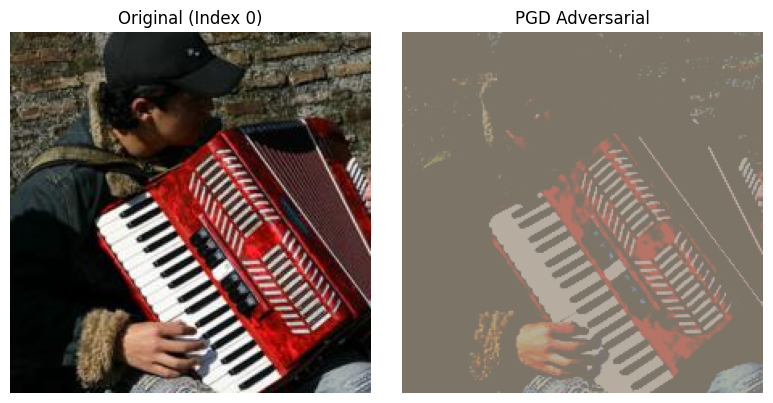

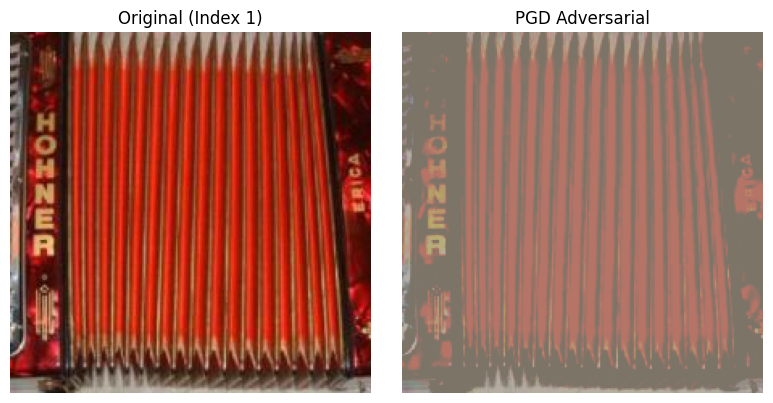

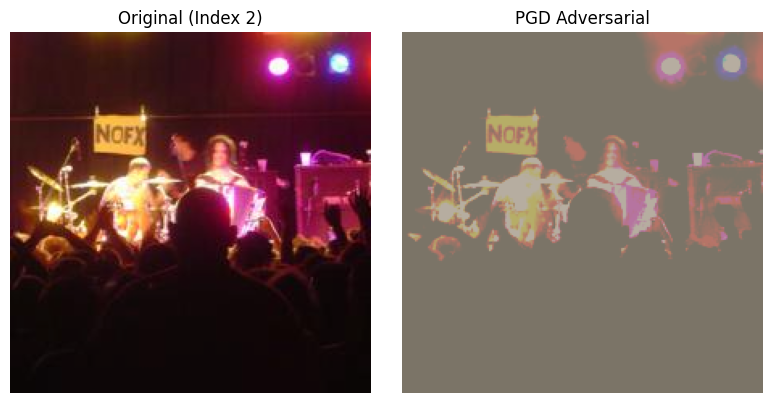

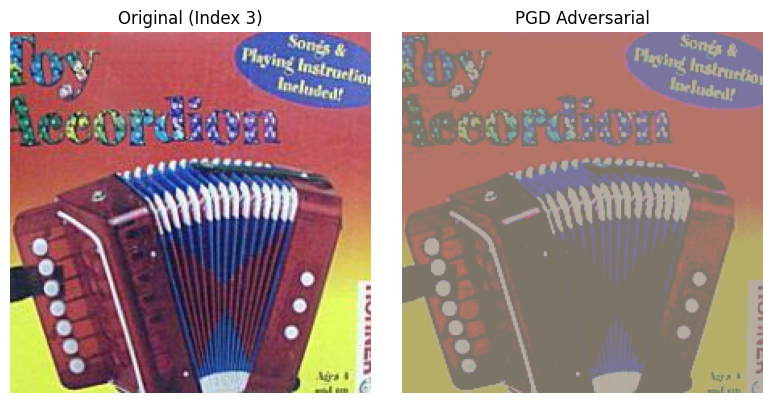

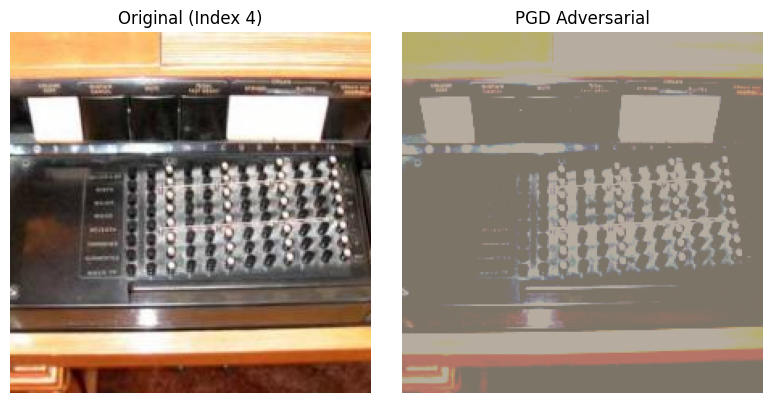

In [ ]:
# ==============================================================================
# Visualize Original vs. Adversarial Images (for Changed Predictions)
# ==============================================================================

print("\n Original vs. Adversarial Image Comparison (Changed Predictions):")

visualized = 0
for i, (adv_img, changed) in enumerate(zip(adv_images, pred_changed)):
    if changed:
        # Get and denormalize original image
        original_img = imagefolder[i][0]  # This applies the transform
        original_img = inv_normalize(original_img).clamp(0, 1).permute(1, 2, 0)

        # Get and denormalize adversarial image
        adversarial_img = inv_normalize(adv_img).clamp(0, 1).permute(1, 2, 0)

        # Plot side-by-side
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(original_img)
        axes[0].set_title(f"Original (Index {i})")
        axes[0].axis("off")

        axes[1].imshow(adversarial_img)
        axes[1].set_title("PGD Adversarial")
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()

        visualized += 1
        if visualized == NUM_VIS_EXAMPLES:
            break


In [55]:
# Create DataLoader for Adversarial Examples (for Evaluation)

class AdvDataset(Dataset):
    
    def __init__(self, image_tensors, labels):
        self.image_tensors = image_tensors
        self.label_list = labels

    def __len__(self):
        return len(self.image_tensors)

    def __getitem__(self, index):
        return self.image_tensors[index], self.label_list[index]

# --- Instantiate Dataset and DataLoader ---
adv_dataset = AdvDataset(adv_images, true_labels)
adv_loader = DataLoader(adv_dataset, batch_size=32)


### Explanation of our `evaluate` Function

Define the `evaluate` function to compute Top-1 and Top-5 accuracy of the model on a given dataset, as required by the task.

- **Inputs**:
  - `model`: Neural network model (e.g., ResNet-34).
  - `dataloader_to_eval`: Dataset loader (e.g., clean or adversarial).

- **Our Approach**:
  - Set the model to evaluation mode.
  - Initialize counters for Top-1, Top-5 correct predictions, and total samples.
  - Iterate through batches, moves data to `DEVICE`.
  - Compute model outputs.
  - Calculate Top-1 accuracy by checking if the top prediction matches the true label.
  - Calculate Top-5 accuracy by checking if the true label is among the top 5 predictions.
  - Update counters and computes final percentages.

In [56]:
def evaluate(model, dataloader):

    top1_correct = 0
    top5_correct = 0
    total_samples = 0

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)

            _, top1 = outputs.topk(1, dim=1)
            _, top5 = outputs.topk(5, dim=1)

            top1_correct += (top1.squeeze() == labels).sum().item()
            top5_correct += sum([
                labels[i] in top5[i] for i in range(labels.size(0))
            ])
            total_samples += labels.size(0)

    top1_acc = 100 * top1_correct / total_samples
    top5_acc = 100 * top5_correct / total_samples
    return top1_acc, top5_acc


In [57]:
# Evaluate Model on Adversarial Examples

top1_adv, top5_adv = evaluate(resnet34, adv_loader)

print("\nPGD Adversarial Evaluation Results:")
print(f"Top-1 Accuracy: {top1_adv:.2f}%")
print(f"Top-5 Accuracy: {top5_adv:.2f}%")



PGD Adversarial Evaluation Results:
Top-1 Accuracy: 1.00%
Top-5 Accuracy: 10.20%


### Conclusion

The PGD adversarial attack significantly degraded the ResNet-34 model's performance on "Adversarial Test Set 2":

- **Top-1 Accuracy**: 1.00%
- **Top-5 Accuracy**: 10.20%

This reflects a substantial accuracy drop, surpassing the target of at least **70% degradation** relative to the baseline.  
The adversarial examples respect the **$\epsilon = 0.02$ constraint**, maintaining visual similarity to the original images while effectively causing misclassifications.
